In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit  # import the curve fitting function
%matplotlib inline

## 0. Calibrate MCA Channels to sources of known emission energy

In [2]:
CS137Peaks = np.array([165.85]) #Channel Number of photopeak
CS137Energy = np.array([661.7]) #Accepted value of emission energy

In [3]:
BA133Peaks = np.array([21.59, 76.76, 90.52])
BA133Energy = np.array([81.0, 302.9, 356.0])

In [4]:
Mn54Peaks = np.array([207.72])
Mn54Energy = np.array([834.8])

In [5]:
Na22Peaks = np.array([128.84])
Na22Energy = np.array([511.0])

In [6]:
CO57Peaks = np.array([31.98])
CO57Energy = np.array([122.1])

In [7]:
Peaks = np.hstack([CS137Peaks,BA133Peaks,Mn54Peaks,Na22Peaks,CO57Peaks])

In [8]:
Energy = np.hstack([CS137Energy,BA133Energy,Mn54Energy,Na22Energy,CO57Energy])

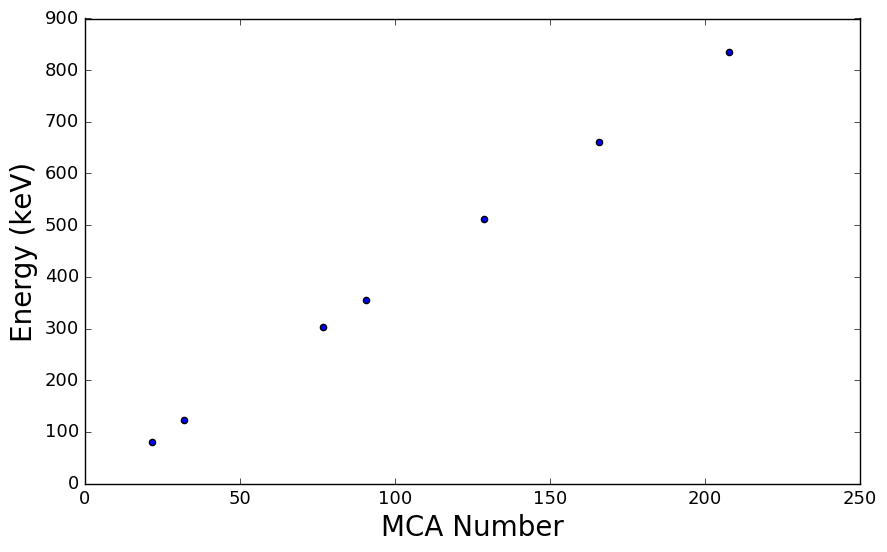

In [9]:
plt.figure(figsize=(10,6));
plt.scatter(Peaks,Energy);

plt.xlabel('MCA Number',fontsize=20);
plt.ylabel('Energy (keV)',fontsize = 20);
plt.xticks(size = 13);
plt.yticks(size = 13);
#plt.savefig('Sample')

In [10]:
def myfun(N,a,b,c):
    ans = a + b*N + c*N**2  # this is y, "the function to be fit"
    return ans

In [11]:
p0 = [-2,1,0]

In [12]:
xlots = np.linspace(0,240)  # need lots of data points for smooth curve
yfit = np.zeros((len(Peaks),xlots.size))

plsq, pcov = curve_fit(myfun, Peaks, Energy, p0)  # curve fit returns p and covariance matrix
# these give the parameters and the uncertainties
a = plsq[0]
da = np.sqrt(pcov[0,0])
b = plsq[1]
db = np.sqrt(pcov[1,1])
c = plsq[2]
dc = np.sqrt(pcov[2,2])

yfit = myfun(xlots,plsq[0],plsq[1],plsq[2])  # use fit results for a, b, c
    
print('a = %.7f +/- %.7f' % (plsq[0], np.sqrt(pcov[0,0])))
print('b = %.7f +/- %.7f' % (plsq[1], np.sqrt(pcov[1,1])))
print('c = %.7f +/- %.7f' % (plsq[2], np.sqrt(pcov[2,2])))

a = -4.1625646 +/- 1.1462859
b = 3.9444426 +/- 0.0246152
c = 0.0004452 +/- 0.0001070


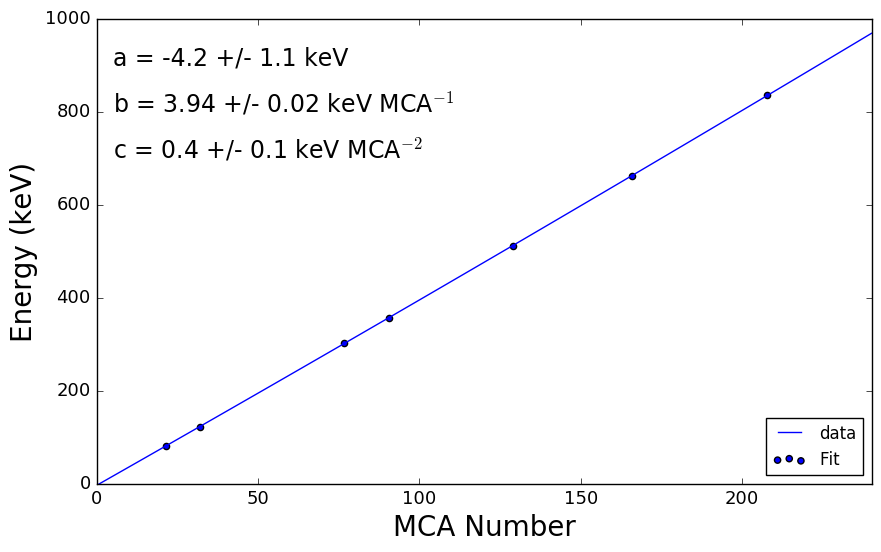

In [13]:
plt.figure(figsize=(10,6));
plt.scatter(Peaks,Energy);
plt.xlim(0,240)
plt.ylim(0,1000)
plt.xlabel('x (mm)');
plt.ylabel('y (mm)');
plt.plot(xlots,yfit);
plt.legend(['data','Fit'],loc='lower right');
plt.text(5,900,'a = %.1f +/- %.1f keV' % (plsq[0], np.sqrt(pcov[0,0])),size=17)
plt.text(5,800,'b = %.2f +/- %.2f keV MCA$^{-1}$' % (plsq[1], np.sqrt(pcov[1,1])),size=17)
plt.text(5,700,'c = %.1f +/- %.1f keV MCA$^{-2}$' % (plsq[2]*1e3, np.sqrt(pcov[2,2])*1e3),size=17)
plt.xlabel('MCA Number',fontsize=20);
plt.ylabel('Energy (keV)',fontsize = 20);
plt.xticks(size = 13);
plt.yticks(size = 13);
plt.savefig('LinearMCAFit')

## 1. Test how the energy of scattered atoms varies with scattering angle

In [14]:
N = np.array([102.20, 85.85, 121.57, 140.34, 127.77, 115.69]) #Photopeak channel of scattered rays
dN = np.array([5.37, 8.01, 5.13, 5.54, 8.91, 5.5]) #Uncertainty in channel number
theta = np.array([60, 75, 45, 30, 40, 50])*np.pi/180 #Scattering angle entered in degrees converted to radians afterwords

In [15]:
def deltaE(N,dN):
    dbN = np.sqrt((db/b)**2 + (dN/N)**2)*(b*N)

    dcN2 = np.sqrt((dc/c)**2 + 4*(dN/N)**2)*(c*N**2)

    dEMeas = np.sqrt(da**2 + dbN**2 + dcN2**2)
    
    return dEMeas

In [16]:
EMeas = myfun(N,a,b,c)
EMeas

array([ 403.60963367,  337.74914147,  481.94322356,  558.16909454,
        507.08702403,  458.1287912 ])

In [17]:
dEMeas = deltaE(N,dN)
dEMeas

array([ 21.39610988,  31.7020477 ,  20.55562878,  22.26407277,
        35.36178034,  21.96462655])

In [18]:
Eo = 661.7 #Initial keV energy of gamma rays (before scattering) 
mc2 = 511 #electron mass in keV

In [19]:
def ECompton(Eo,mc2,theta):
    return Eo/(1+(Eo/mc2)*(1-np.cos(theta)))

In [20]:
EComp = ECompton(Eo,mc2,theta)
EComp

array([ 401.64958128,  337.64268434,  479.7462107 ,  563.87583021,
        507.84685815,  452.42632005])

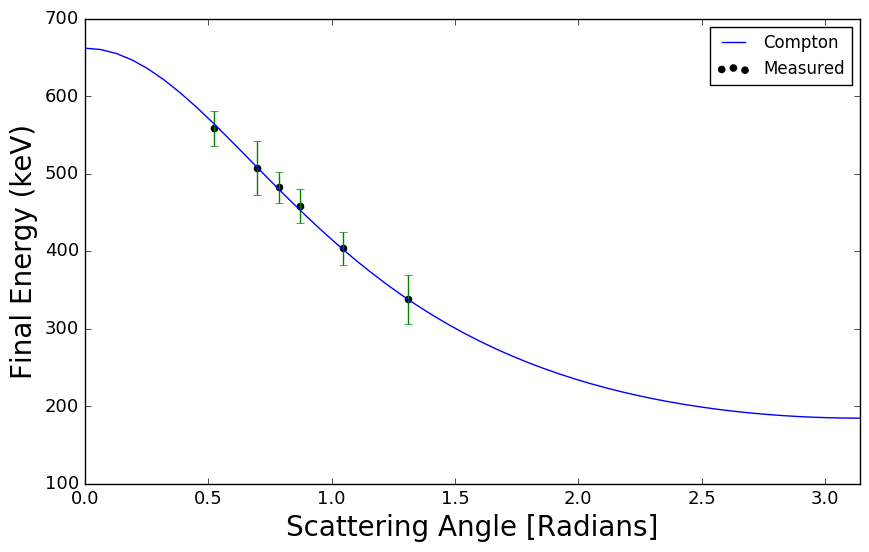

In [21]:
thetas = np.linspace(0,np.pi,50);

plt.figure(figsize=(10,6));
plt.plot(thetas,ECompton(Eo,mc2,thetas),label='Compton');
plt.errorbar(theta,EMeas,yerr = dEMeas,fmt='none');
plt.scatter(theta,EMeas,label='Measured',color='k');
plt.legend();

plt.xlabel('Scattering Angle [Radians]',fontsize=20);
plt.ylabel('Final Energy (keV)',fontsize = 20);
plt.xticks(size = 13);
plt.yticks(size = 13);
plt.xlim(0,np.pi);
plt.savefig('ComptonEnergy')

## 2. Use (1) to determine keV mass of electron

In [22]:
y = np.array([1/entry for entry in EMeas])
dy = np.array([dEMeas[i]/EMeas[i]**2 for i in np.arange(len(EMeas))])

In [23]:
x = np.array([1-np.cos(entry) for entry in theta])

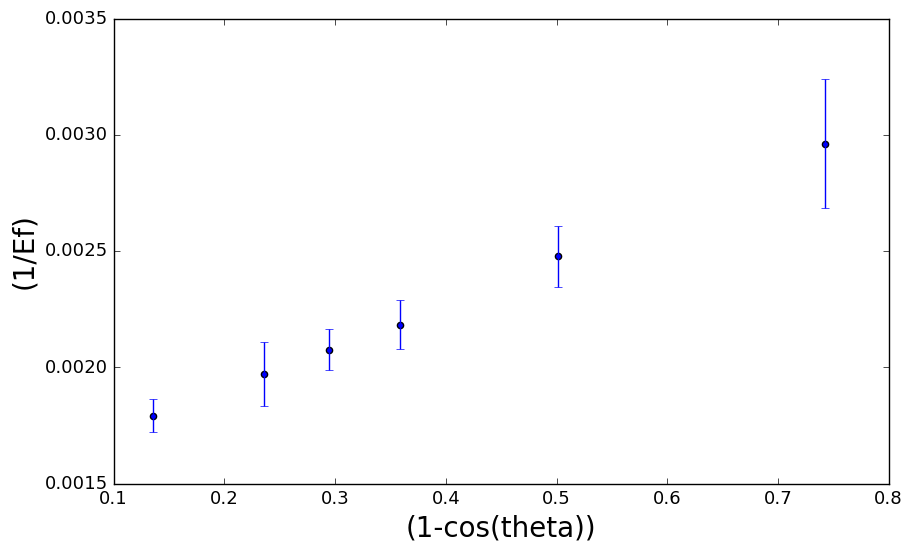

In [24]:
plt.figure(figsize=(10,6));
plt.scatter(x + 1/Eo,y);
plt.errorbar(x + 1/Eo,y,dy,fmt='none')

plt.xlabel('(1-cos(theta))',fontsize=20);
plt.ylabel('(1/Ef)',fontsize = 20);
plt.xticks(size = 13);
plt.yticks(size = 13);
plt.ylim(0.0015,0.0035);

In [25]:
def myfun2(x,mc2):
    # x = (1-np.cos(theta))
    return 1/Eo + (1/mc2)*x

In [26]:
p02 = [511]

In [27]:
xlots2 = np.linspace(0,1)  # need lots of data points for smooth curve
yfit = np.zeros((len(Peaks),xlots2.size))

plsq, pcov = curve_fit(myfun2, np.array([1-np.cos(entry) for entry in theta]), np.array([1/entry for entry in EMeas]), p02)  # curve fit returns p and covariance matrix
# these give the parameters and the uncertainties
mc2Meas = plsq[0]
dmc2Meas = np.sqrt(pcov[0,0])

yfit2 = myfun2(xlots2,plsq[0])  # use fit results for a, b, c
    
print('mc2Meas = (%.1f +/- %.1f) keV/c2' % (plsq[0], np.sqrt(pcov[0,0])))

mc2Meas = (514.9 +/- 3.8) keV/c2


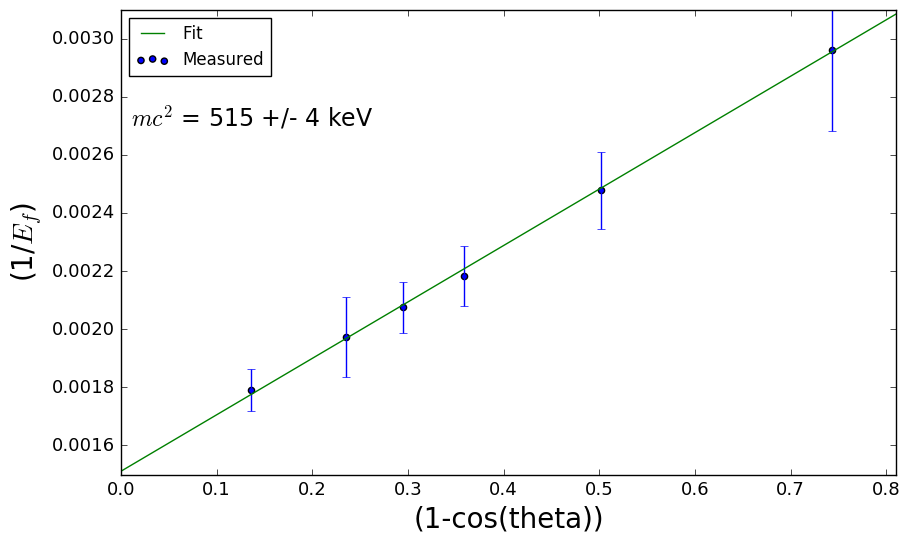

In [28]:
plt.figure(figsize=(10,6));
plt.scatter(x + 1/Eo,y,label='Measured');
plt.errorbar(x + 1/Eo,y,dy,fmt='none')
plt.plot(xlots2,yfit2,label='Fit')
plt.legend(loc='upper left')

plt.xlabel('(1-cos(theta))',fontsize=20);
plt.ylabel('(1/$E_f$)',fontsize = 20);
plt.xticks(size = 13);
plt.yticks(size = 13);
plt.ylim(0.0015,0.0031);
plt.xlim(0,0.81)
plt.text(0.01,0.0027,'$mc^2$ = %.0f +/- %.0f keV' % (plsq[0], np.sqrt(pcov[0,0])),size=17)
plt.savefig('ElectronMass')

## 3. Which of Thomson and Klein-Nishina differential cross section is a better description?

In [29]:
EMeas #For determining efficiency from manual

array([ 403.60963367,  337.74914147,  481.94322356,  558.16909454,
        507.08702403,  458.1287912 ])

In [30]:
Counts = np.array([2446, 1513, 3357, 3231, 1285, 1944])

#This is the detector efficiency which is a function of the incoming gamma energy (EMeas)
e = np.array([0.6, 0.67, 0.52, 0.475, 0.51, 0.55]) 

Counts = np.array([Counts[i]/e[i] for i in np.arange(len(Counts))])
unc = np.array([np.sqrt(entry) for entry in Counts])

Time = np.array([1531.76, 1952.72, 1970.43, 629.12, 663.42, 750.65])
Rates = np.array([Counts[i]/Time[i] for i in np.arange(len(Counts))])
unc = np.array([unc[i]/Time[i] for i in np.arange(len(Counts))])

In [31]:
def Thomson(theta):
    ro = 2.82*1e-15
    return (1/2)*(ro**2)*(1+np.cos(theta)**2)*1.20e30 #set b = 1

In [32]:
def KleinNishina(theta):
    ro = 2.82*1e-15
    gamma = Eo/mc2
    
    return (1/2)*(ro**2)*(1+np.cos(theta)**2)*((1+gamma*(1-np.cos(theta)))**(-2))*(1+((gamma*(1-np.cos(theta)))**2)/((1+np.cos(theta)**2)*(1+gamma*(1-np.cos(theta)))))*1.2e30

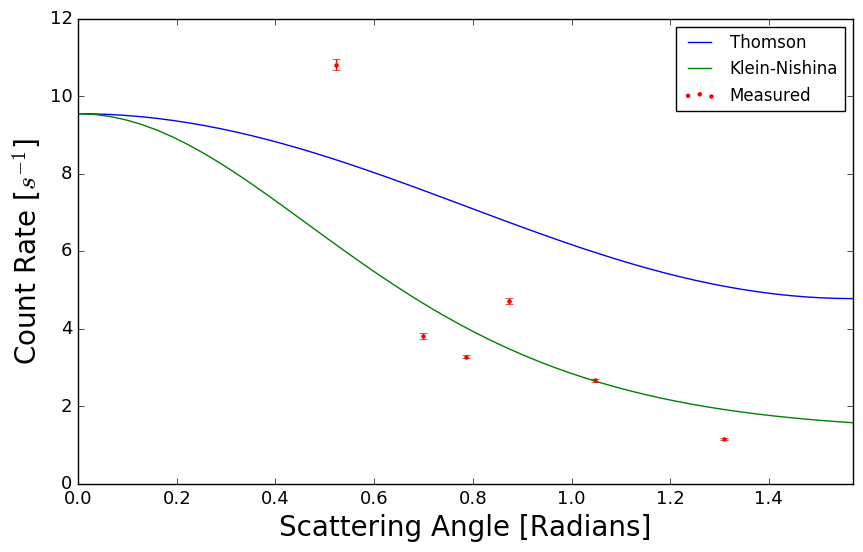

In [33]:
thetas = np.linspace(0,np.pi/2,50);

plt.figure(figsize=(10,6));
plt.plot(thetas,Thomson(thetas),label='Thomson');
plt.plot(thetas,KleinNishina(thetas),label='Klein-Nishina');
plt.scatter(theta,Rates,label='Measured',marker = '.',color='red')
plt.errorbar(theta,Rates,unc,fmt='none')
plt.legend();

plt.xlabel('Scattering Angle [Radians]',fontsize=20);
plt.ylabel('Count Rate [$s^{-1}$]',fontsize = 20);
plt.xticks(size = 13);
plt.yticks(size = 13);
plt.xlim(0,np.pi/2);
plt.savefig('ThomsonKleinNishina')